In [2]:
def load_stopwords():
        """
        :return: 加载好的停用词列表
        """
        with open('../hit_stopwords.txt', 'r', encoding='UTF-8') as f:
            lines = f.readlines()
            stopwords = []
            for line in lines:
                stopwords.append(line.replace('\n', ''))
        return stopwords

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\DYL\AppData\Local\Temp\jieba.cache
Loading model cost 0.718 seconds.
Prefix dict has been built successfully.


375/375 [==============================] - 1s 3ms/step - loss: 0.3121 - accuracy: 0.9244
Test loss: 0.3120572566986084
Test accuracy: 0.924410343170166
375/375 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      5922
           1       0.94      0.91      0.92      6077

    accuracy                           0.92     11999
   macro avg       0.92      0.92      0.92     11999
weighted avg       0.92      0.92      0.92     11999



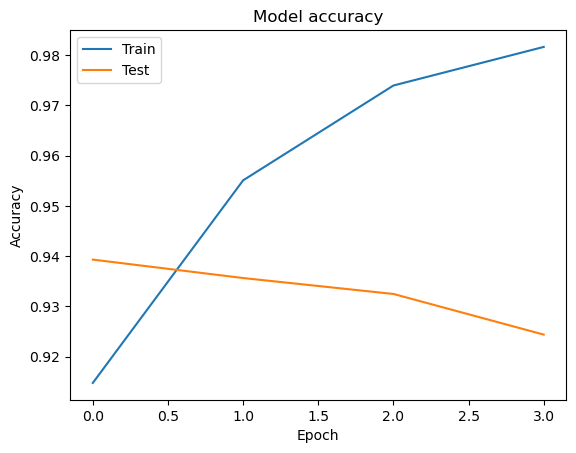

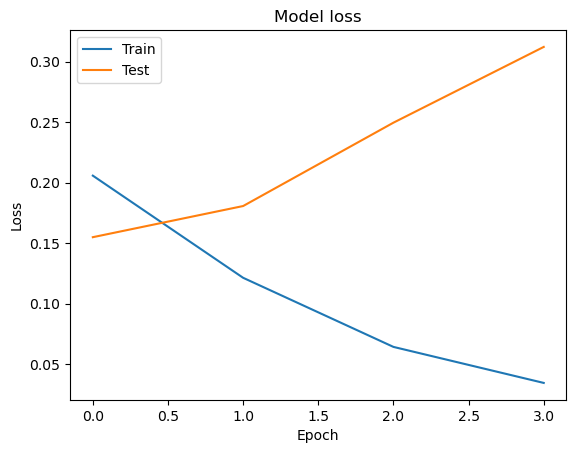

KeyboardInterrupt: 

In [3]:
from sklearn.metrics import classification_report
from keras.utils import pad_sequences
import pandas as pd
import jieba
import tensorflow as tf
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import re

with tf.device('/gpu:0'):
    # 读取我们本次实验的文本数据
    df = pd.read_csv('../Emotional_text/weibo_sentiment.csv')

    # 分词并去除停用词
    stop_words = load_stopwords()
    df['review'] = df['review'].apply(lambda x: re.sub(r'\d+', '', x))
    df['review'] = df['review'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    df['review'] = df['review'].apply(lambda x: x.replace(" ", ""))
    df['review'] = df['review'].apply(lambda x: ' '.join(word for word in jieba.cut(x) if word not in stop_words))

    # 使用Keras的Tokenizer来转化词语为词向量，这里我们选择出现频率前25000个词作为词袋
    tokenizer = Tokenizer(num_words=25000, oov_token='<OOV>')
    tokenizer.fit_on_texts(df['review'])
    seq = tokenizer.texts_to_sequences(df['review'])

    # 补齐每个样本序列，使其长度一样来方便后续的计算
    max_len = 280
    seq = pad_sequences(seq, maxlen=max_len, truncating='post')

    # 划分数据集，这里我们使用十折交叉验证，循环十次训练
    labels = df['label']
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    losses = []
    accs = []
    for train_idx, test_idx in kfold.split(seq, labels):
        # 划分训练集和测试集
        train_seq, test_seq = seq[train_idx], seq[test_idx]
        train_labels, test_labels = labels.iloc[train_idx], labels.iloc[test_idx]

        # 建立一个神经网络模型，一层层添加神经元层
        model = Sequential()
        model.add(Embedding(25000, 150, input_length=max_len))
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(GlobalMaxPooling1D())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(2, activation='softmax'))

        # 编译刚刚建立的卷积神经网络模型
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # 设置 EarlyStopping 和 ReduceLROnPlateau 来避免过拟合
        early_stop = EarlyStopping(monitor='val_loss', patience=3)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

        # 训练以及验证卷积神经网络模型的效果
        history = model.fit(train_seq, tf.keras.utils.to_categorical(train_labels), batch_size=128, epochs=20, validation_data=(test_seq, tf.keras.utils.to_categorical(test_labels)), callbacks=[early_stop, reduce_lr], verbose=0)

        # 评估本实验建立的卷积神经网络模型的训练结果的各项参数
        loss, accuracy = model.evaluate(test_seq, tf.keras.utils.to_categorical(test_labels))
        print('Test loss:', loss)
        print('Test accuracy:', accuracy)
        losses.append(loss)
        accs.append(accuracy)
        y_pred = np.argmax(model.predict(test_seq), axis=-1)
        print(classification_report(test_labels, y_pred))

        # 绘制训练集和测试集的损失和准确率变化曲线
        import matplotlib.pyplot as plt
        %matplotlib inline

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    print('Mean loss:', np.mean(losses))
    print('Mean accuracy:', np.mean(accs))

In [5]:
import re

# 准备数据
new_text = "我真的好伤心，要哭成泪人了，有没有小伙伴来同情一下我啊，我好难受"

new_text = re.sub(r'\d+', '', new_text)

new_text = re.sub(r'[^\w\s]', '', new_text)

new_text = new_text.replace(" ", "")

# 分词并去除停用词
new_text = [' '.join(word for word in jieba.cut(new_text) if word not in stop_words)]

# 词向量化
seq = tokenizer.texts_to_sequences(new_text)
padded = pad_sequences(seq, maxlen=max_len, truncating='post')

# 预测
predictions = model.predict(padded)

# 解析结果
predicted_labels = np.argmax(predictions, axis=1)

print(predicted_labels)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\DYL\AppData\Local\Temp\jieba.cache
Loading model cost 0.735 seconds.
Prefix dict has been built successfully.


NameError: name 'tokenizer' is not defined